In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import os

In [2]:
dfs = []
for net in ["_emlp"]:
    for ds in ["O5Synthetic","Inertia","ParticleInteraction"]:
        path = os.path.expanduser(f'~/equivariant-MLP/experiments/aws_expts/experiments/data_efficiency_nobn{net}_{ds}/results.df')
        if ds=="ParticleInteraction" and net=="_emlp":
            path = os.path.expanduser('~/equivariant-MLP/experiments/aws_expts/experiments/experiments/data_efficiency_nobn_emlp_ParticleInteraction/results.df')
        with open(path,'rb') as f:
            df = pickle.load(f)
            df['dataset'] = ds
            if 'network' in df.columns:
                assert net==""
                df = df.drop(df[df['network']=='EMLP'].index)
                df.loc[(df['aug']==False),'method'] = "MLP"
                df.loc[(df['aug']==True),'method'] = "MLP+Aug"
            else:
                #print(df.head())
                #if len(df)<10: continue
                df["method"] = "EMLP-"+df["group"].astype(str)
        
        dfs.append(df)
df = pd.concat(dfs)


In [3]:
path = os.path.expanduser("~/equivariant-MLP/experiments/aws_expts/mlp_nobn_results.df")
with open(path,'rb') as f:
    dfm = pickle.load(f)
    dfm.loc[(dfm['aug']==False),'method'] = "MLP"
    dfm.loc[(dfm['aug']==True),'method'] = "MLP+Aug"
df = pd.concat([dfm,df])

In [4]:
#df.to_pickle("./synthetic_results_all.pkl")

In [5]:
#df =  pd.read_pickle("./synthetic_results_all.pkl")

In [6]:
df.loc[df['method']=="EMLP-SO13","method"]="EMLP-SO(1,3)"
df.loc[df['method']=="EMLP-O13","method"]="EMLP-O(1,3)"
df.loc[df['method']=="EMLP-SO13p","method"]=r"EMLP-SO$^+$(1,3)"
df.loc[df['method']=="EMLP-SO[5]","method"]=r"EMLP-SO(5)"
df.loc[df['method']=="EMLP-O[5]","method"]=r"EMLP-O(5)"
df.loc[df['method']=="EMLP-SO[3]","method"]=r"EMLP-SO(3)"
df.loc[df['method']=="EMLP-O[3]","method"]=r"EMLP-O(3)"

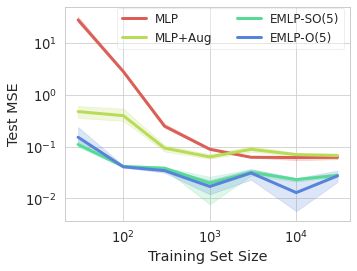

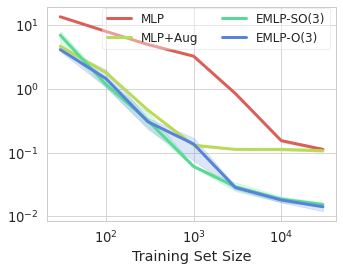

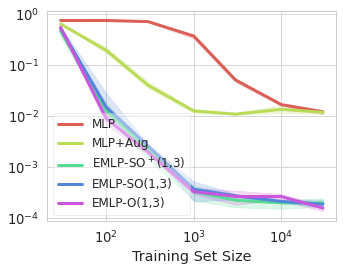

In [7]:
from matplotlib import rc
import seaborn as sns
#rc('text', usetex=True)
#rc('text.latex', preamble=r'\usepackage{sansmath}')#, r'\sansmath']) #r'\usepackage{DejaVuSans}'
# rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':44},)
# rc('xtick.major', pad=12)
# rc('ytick.major', pad=12)
# rc('grid', linewidth=1.3)
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5) 
#sns.set(font_scale=2)

#fig, ax = plt.subplots(1, 3, figsize=(15, 5))#, sharey=True)
pall = sns.color_palette("hls", 5)
colors = ["#00abdf", "#00058A", "#6A0078", (96/255,74/255,123/255), "#8E6100"]

#ax[0].set_yscale('log')
#ax[1].set_ylim((1e-5,1))
#ax[0].set_ylabel('Test MSE')
#ax[0].set_ylabel(r'$y_{2}$')
#ax[1].set_xlabel("Time (seconds)")
#handles, labels = ax[0].get_legend_handles_labels()
#labels[-1] = 'NeuralODE'
for i,ds in enumerate(df['dataset'].unique()):
    figsize = (5.2,4) if ds == "O5Synthetic" else (5,4)
    fig, ax = plt.subplots(1, 1, figsize=figsize)#, sharey=True)
    dfa = df[df['dataset']==ds]
    #dfa = dfa.drop(dfa[dfa['group']=='Trivial[5]'].index)
    #df[dfa['network']=="MLP"]
    pal = pall[:len(dfa['method'].unique())]
    sns.lineplot(ax=ax,data=dfa,x='train',y='test_MSE',hue='method',palette=pal,lw=3)
    plt.legend(loc='upper left')
    ax.set(xscale="log", yscale="log")
    ax.set_xlabel("Training Set Size")
    if ds=="O5Synthetic":
        ax.set_ylabel("Test MSE")
    else:
        ax.set_ylabel("")
    handles, labels = ax.get_legend_handles_labels()
    if ds=="ParticleInteraction":
        leg = ax.legend(handles=handles, labels=labels,loc="best",frameon=True,prop={'size': 12},framealpha=.4)
    else:
        leg = ax.legend(handles=handles, labels=labels,loc="upper right",frameon=True,ncol=2,prop={'size': 12},bbox_to_anchor=(1,1.025),framealpha=.4)
    for line in leg.get_lines():
        line.set_linewidth(3.0)
    #ax.legend(loc='upper left', frameon=False)
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
#plt.xlabel('Training Examples')
#plt.yscale('log')
#plt.xscale('log')
    #plt.title(f"{ds}")
    
    plt.tight_layout()
    plt.savefig(f'data_efficiency_{ds}.pdf', bbox_inches='tight')
    plt.show()

In [8]:
import glob
import torch
import jax.numpy as jnp
import numpy as np
from jax import vmap
import jax
def rel_err(a,b):
    return jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean()))#
verr = vmap(vmap(rel_err))
v1err = vmap(vmap(rel_err,(0,None)))

In [9]:
paths = glob.glob(os.path.expanduser("~/equivariant-MLP/experiments/aws_expts/rollouts2/*.t"))
rollouts = {pth.split('/')[-1]:torch.load(pth) for pth in paths}

rollout_data = []
for pth,z in rollouts.items():
    pred,gt = z[...,0],z[...,1]
    #pred = pred[:,:pred.shape[1]//2]
    #gt = gt[:,:gt.shape[1]//2]
    errs = verr(pred,gt) # (bs,T,)
    clamped_errs = jax.lax.clamp(1e-5,errs,np.inf)
    geo_mean_err = np.exp(jnp.log(clamped_errs).mean())
    qs = pred[...,:6]
    ps = pred[...,6:]
    zang_mom = qs[...,0]*ps[...,1]-qs[...,1]*ps[...,0] + qs[...,0+3]*ps[...,1+3]-qs[...,1+3]*ps[...,0+3]
    clamped_errs = jax.lax.clamp(1e-5,v1err(zang_mom,zang_mom[:,0]),np.inf)
    angmom_geomean_err = np.exp(jnp.log(clamped_errs).mean())
    words = pth.split('_')
    group = words[1].replace('[','(').replace(']',')')
    rollout_data.append({'model':words[0],'group':group,'state_err':geo_mean_err,'ang_err':angmom_geomean_err,'pred':pred,'gt':gt})
#     if words[0][0]=='E':
#         print(np.isnan(pred).mean())
#         print(clamped_errs0.mean(0))
#         plt.plot(np.exp(jnp.log(clamped_errs0).mean(0)))
#         plt.yscale('log')
#         plt.ylim((1e-4,1))
#         plt.title(f'{words[0]}, {group}')
#         plt.show()
ddf = pd.DataFrame(rollout_data) 

<ipython-input-9-f58ae5ca9818>:14: RuntimeWarning: overflow encountered in multiply
  zang_mom = qs[...,0]*ps[...,1]-qs[...,1]*ps[...,0] + qs[...,0+3]*ps[...,1+3]-qs[...,1+3]*ps[...,0+3]
<ipython-input-9-f58ae5ca9818>:14: RuntimeWarning: overflow encountered in subtract
  zang_mom = qs[...,0]*ps[...,1]-qs[...,1]*ps[...,0] + qs[...,0+3]*ps[...,1+3]-qs[...,1+3]*ps[...,0+3]
<ipython-input-9-f58ae5ca9818>:14: RuntimeWarning: invalid value encountered in subtract
  zang_mom = qs[...,0]*ps[...,1]-qs[...,1]*ps[...,0] + qs[...,0+3]*ps[...,1+3]-qs[...,1+3]*ps[...,0+3]


In [10]:
ddf = ddf[~np.isnan(ddf['ang_err'])]

In [11]:
for group in ['D(2)','D(6)','SO(2)','O(2)']:
    for model in ['EMLPH','EMLPode']:
        subset = ddf[(ddf['group']==group)&(ddf['model']==model)]
        print(group,model,subset['state_err'].mean(),subset['state_err'].std())
subset = ddf.loc[ddf['model']=='MLPH','state_err']
print("MLPH",subset.mean(),subset.std())
subset = ddf.loc[ddf['model']=='MLPode','state_err']
print("MLPode",subset.mean(),subset.std())

D(2) EMLPH 0.08606978063471615 0.1452640734287258
D(2) EMLPode 0.029302938655018807 0.012075289439243558
D(6) EMLPH 0.013230646587908268 0.0021366766395866663
D(6) EMLPode 0.03608374918500582 0.02587562337855197
SO(2) EMLPH 0.014531210251152515 0.002672895436651871
SO(2) EMLPode 0.05176456769307455 0.035672780575026694
O(2) EMLPH 0.01213430822826922 0.0017882616090916425
O(2) EMLPode 0.01918771304190159 0.0013149474292254786
MLPH 0.02809058440228303 0.0011293867511942106
MLPode 0.04815062880516052 0.0001657919150134691


In [12]:
#ddf2 = ddf.drop(ddf[(ddf['model']=='EMLPode')&(ddf['group']!='SO(2)')].index)
ddf2 = ddf.copy()
ddf2.loc[(ddf2['model']!="EMLPH")&(ddf2['model']!="EMLPode"),'group']='MLP'
ddf2['method'] = ddf2['group']


In [13]:
ddf2.loc[(ddf2['method']=='D(2)'),'order']=0
ddf2.loc[(ddf2['method']=='D(6)'),'order']=0
ddf2.loc[(ddf2['method']=='SO(2)'),'order']=1
ddf2.loc[(ddf2['method']=='O(2)'),'order']=1
ddf2.loc[(ddf2['method']=='MLPH'),'order']=2
ddf2.loc[(ddf2['method']=='EMLPode'),'order']=3
ddf2.loc[(ddf2['method']=='MLPode'),'order']=4
ddf2.loc[(ddf2['method']=='MLPode'),'method']='None'
ddf2.loc[(ddf2['method']=='MLPH'),'method']='None'
ddf2['method2']='HNNs'
ddf2.loc[(ddf2['model']=='MLPode')|(ddf2['model']=='EMLPode'),'method2']='Neural ODEs'

In [14]:
ddf2 = ddf2.sort_values(['order']).reset_index(drop=True)

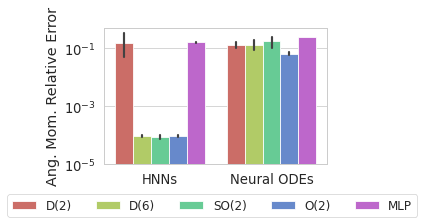

In [15]:
pall = sns.color_palette("hls", 5)
fig, ax = plt.subplots(figsize=(4,3))
sns.barplot(data=ddf2, x="method2", y="ang_err",palette=pall,
             ci=95, ax=ax, hue="method")
ax.set(yscale="log", ylabel="Ang. Mom. Relative Error", xlabel=None,
       title='',#r"$\hat{z}$-angular momentum relative error over 100 timesteps (3D Systems)",
       ylim=(1e-5, 5e-1))
ax.legend().remove()

#xlabels = [f"{system}" for system in data["Body"].unique()]
#ax.set_xticklabels(xlabels, rotation=0)

handles, labels = ax.get_legend_handles_labels()
fig.subplots_adjust(bottom=0.25)
fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 0., 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1,prop={'size': 12})
#fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 0.04, 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1, mode="expand")
#plt.tight_layout()
plt.savefig('angular_momentum_wlegend.pdf', bbox_inches='tight')
plt.show()

In [16]:
#ddf2[['method2','group']]

(150,)
(150,)
(150,)
(150,)


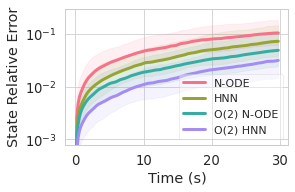

In [37]:
pall2 = sns.color_palette("husl", 4)
fig, ax = plt.subplots(figsize=(4,2.5))
for n,i in enumerate([32,31,24,29]):
    pred,gt = ddf2.iloc[i]["pred"],ddf2.iloc[i]["gt"]
    errs = verr(pred,gt) # (bs,T,)
    clamped_errs = jax.lax.clamp(1e-7,errs,np.inf)
    rel_errs = np.exp(jnp.log(clamped_errs).mean(0))
    rel_stds = np.exp(jnp.log(clamped_errs).std(0))
    print(rel_errs.shape)
    T = np.arange(0,30,.2)
    plt.plot(T,rel_errs,label=ddf2.iloc[i]['method2']+ddf2.iloc[i]['group'],lw=3,color=pall2[n])
    #plt.fill_between(T, rel_errs+rel_stds, rel_errs-rel_stds,alpha=.2)
    plt.fill_between(T, rel_errs/rel_stds, rel_errs*rel_stds,alpha=.1,color=pall2[n])
plt.xlabel('Time (s)')
plt.ylabel('State Relative Error')
plt.yscale('log')
plt.ylim(8e-4,3e-1)
plt.legend(["N-ODE", "HNN","O(2) N-ODE","O(2) HNN"],loc="best",frameon=True,prop={'size': 11},framealpha=.4)
plt.savefig('rollouts_wlegend.pdf', bbox_inches='tight')

In [18]:
gt = ddf2.iloc[20]['gt']

In [29]:
from ipywidgets import interact
from emlp_jax.hamiltonian_dynamics import CoupledPendulumAnimation
ztc = gt[...,:6].reshape(gt.shape[:-1]+(2,3))
print(ztc.shape)
@interact(i=(0,ztc.shape[1]-1),k=(0,ztc.shape[0]-1))
def make_fig(i=60,k=130):
    anim = CoupledPendulumAnimation(ztc[k],lims=((-3,3),(-3,3),(-6,0)),figkwargs={'figsize':(6,6)},
                                    spring_lw=1,traj_lw=2,spring_r=.1)
    anim.init()
    anim.update(i=i)
    #plt.axis('off')
    #plt.show()
    plt.savefig(f"system_axis.pdf", bbox_inches="tight")

(500, 150, 2, 3)


interactive(children=(IntSlider(value=60, description='i', max=149), IntSlider(value=130, description='k', max…